# Correlation Power Analysis
Submitters:
1. Chen Frydman 208009845
2. Hadi Shaheen 315490193

```bash
docker pull annakul1/attacks_on_implementations:Assignment2
docker run -p 80:8080 annakul1/attacks_on_implementations:Assignment2
```

# Imports

In [7]:
import requests
import numpy as np
import time
import os
import concurrent.futures
import matplotlib.pyplot as plt

# Parameters

In [8]:
USER = 208009845
DIFFICULTY = 1
BASE_URL = "aoi-assignment2.oy.ne.ro:8080"
#BASE_URL = "127.0.0.1"
MAX_PLAINTEXT_LENGTH = 32
MAX_KEY_LENGTHH = 32
AMOUNT_OF_TRACES = 10000
TIME_LIMIT = 10 * 60 # 10 minutes in seconds
DIFFICULTY_TO_DOWNLOAD = 30
KEY_LENGTH = 16
PREFIX_TRACES_FILE_NAME = f"traces_{USER}"
PREFIX_PLAINTEXT_FILE_NAME = f"plaintext_{USER}"
PREFIX_ENCRYPT_URL = rf"http://{BASE_URL}/encrypt?user={USER}"
PREFIX_VERIFY_URL = rf"http://{BASE_URL}/verify?user={USER}"

AesSbox = np.array([
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16
], dtype=np.uint8)

print(f"{PREFIX_ENCRYPT_URL}&difficulty={DIFFICULTY}")

http://aoi-assignment2.oy.ne.ro:8080/encrypt?user=208009845&difficulty=1


# Crack the key

In [11]:
def download_power_traces(
    difficulty: int = DIFFICULTY,
    prefix_traces_filename: str = PREFIX_TRACES_FILE_NAME,
    prefix_plaintext_filename: str = PREFIX_PLAINTEXT_FILE_NAME,
    serverURL: str = PREFIX_ENCRYPT_URL,
    number_of_power_traces: int = AMOUNT_OF_TRACES,
):
    os.makedirs("files", exist_ok=True)
    traces_filename = f"{prefix_traces_filename}_{difficulty}_{number_of_power_traces}.txt"
    traces_filepath = os.path.join("files", traces_filename)
    plaintext_filename = f"{prefix_plaintext_filename}_{difficulty}_{number_of_power_traces}.txt"
    plaintext_filepath = os.path.join("files", plaintext_filename)

    if os.path.exists(traces_filepath) and os.path.exists(plaintext_filepath):
        print(f"{traces_filepath} and {plaintext_filepath} already exist. Skipping download.")
        return

    url = f"{serverURL}&difficulty={difficulty}"

    def fetch_trace(_):
        """
        Fetch a single power trace and its corresponding plaintext from the server.
        Args:
            _: Unused argument for the ThreadPoolExecutor.
        Returns:
            nothing, but writes the plaintext and leaks to files.
        """
        session = requests.Session()
        retries = 3
        for attempt in range(retries):
            try:
                resp = session.get(url, timeout=5)
                resp.raise_for_status()
                data = resp.json()
                plaintext = "".join(map(str, data["plaintext"]))
                leaks = " ".join(map(str, data["leaks"]))
                #time.sleep(0.1)  # Add slight delay here
                return plaintext, leaks
            except (requests.RequestException, ValueError) as e:
                if attempt < retries - 1:
                    time.sleep(0.5 * 2 ** attempt)
                else:
                    raise e


    with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
        results = list(executor.map(fetch_trace, range(number_of_power_traces)))

    with open(plaintext_filepath, "w") as plaintext_file, open(traces_filepath, "w") as traces_file:
        for plaintext, leaks in results:
            plaintext_file.write(plaintext + "\n")
            traces_file.write(leaks + "\n")


def getMeansVariances(filename: str):
    """
    Reads the file containing saved power traces and calculates the mean and variance
    of each position in the trace.

    Args:
        filename (str): The name of the file containing the saved power traces.

    Returns:
        tuple: A tuple containing two lists:
            - means (list): A list of means for each position in the trace.
            - variances (list): A list of variances for each position in the trace.
    """
    if not os.path.exists(filename):
        raise FileNotFoundError(f"{filename} does not exist. Please download the power traces first.")

    data = np.loadtxt(filename)
    means = np.mean(data, axis=0)
    variances = np.var(data, axis=0)
    print("Mean\tVariance")
    for m, v in zip(means, variances):
        print(f"{m}\t{v}")
    return means.tolist(), variances.tolist()

In [39]:
hamming_weight_lut = np.array([bin(i).count('1') for i in range(256)], dtype=np.uint8)

def load_plaintexts(fname, amount):
    with open(fname, 'r') as f:
        lines = [line.strip() for _, line in zip(range(amount), f)]

    length = len(lines[0])
    for line in lines:
        if len(line) != length or len(line) % 2 != 0:
            raise ValueError(f"Line: {line}, length: {len(line)}, Plaintext lines have inconsistent or odd length")

    pts = [[int(line[i:i+2], 16) for i in range(0, length, 2)] for line in lines]
    return np.array(pts, dtype=np.uint8)


def load_traces(fname, amount):
    with open(fname, 'r') as f:
        lines = [line.strip() for _, line in zip(range(amount), f)]
    traces = [list(map(float, line.split())) for line in lines]
    return np.array(traces, dtype=np.float32)

def process_byte(byte_idx, plaintexts, traces):
    """
    Process a single byte of the key by calculating the correlation
    between the hamming weight of the intermediate values and the power traces.
    Args:
        byte_idx (int): The index of the byte to process (0-15 for AES).
        plaintexts (np.ndarray): The plaintexts used for encryption, shape (n_traces, key_length).
        traces (np.ndarray): The power traces, shape (n_traces, trace_length).
    Returns:
        string: The best guess for the byte of the key.
    """
    n_traces = traces.shape[0]
    pt_bytes = plaintexts[:, byte_idx]

    guesses = np.arange(256, dtype=np.uint8)
    inter = pt_bytes[:, None] ^ guesses
    sbox_out = AesSbox[inter]

    hw_xor = hamming_weight_lut[inter]
    hw_sbox = hamming_weight_lut[sbox_out]

    hw_xor_norm = (hw_xor - hw_xor.mean(axis=0)) / hw_xor.std(axis=0)
    hw_sbox_norm = (hw_sbox - hw_sbox.mean(axis=0)) / hw_sbox.std(axis=0)

    traces_mean = traces.mean(axis=0)
    traces_std = traces.std(axis=0)
    traces_norm = (traces - traces_mean) / traces_std  # shape (n_traces, trace_length)

    corr_xor = np.abs(np.dot(hw_xor_norm.T, traces_norm) / (n_traces - 1))  # (256, trace_length)
    corr_sbox = np.abs(np.dot(hw_sbox_norm.T, traces_norm) / (n_traces - 1))  # (256, trace_length)

    total_corr = corr_xor.max(axis=1) + corr_sbox.max(axis=1)  # max correlation per guess

    best_guess = np.argmax(total_corr)
    best_corr = total_corr[best_guess]
    print(f"Byte {byte_idx}: Best guess {best_guess:02x}, corr {best_corr:.4f}")
    return best_guess, best_corr


def find_key(plaintext_file, trace_file, amount_of_traces, key_length=KEY_LENGTH):
    plaintexts = load_plaintexts(plaintext_file, amount_of_traces)
    traces = load_traces(trace_file, amount_of_traces)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(
            process_byte,
            range(key_length),
            [plaintexts] * key_length,
            [traces] * key_length,
        ))  # materialize generator into a list

    key_bytes = [guess for guess, _ in results]
    all_correlations = [corr for _, corr in results]

    print(f"Key: {''.join(f'{b:02x}' for b in key_bytes)}")
    return ''.join(f"{b:02x}" for b in key_bytes), np.mean(all_correlations)

# Pre Download the files

In [ ]:
for difficulty in range(30, 50):
    download_power_traces(difficulty)
    print(f"Downloaded {AMOUNT_OF_TRACES} traces for difficulty level {difficulty}.")
print(f"Downloaded {AMOUNT_OF_TRACES} traces for each difficulty level up to {DIFFICULTY_TO_DOWNLOAD}.")

files\traces_208009845_30_10000.txt and files\plaintext_208009845_30_10000.txt already exist. Skipping download.
Downloaded 10000 traces for difficulty level 30.
Downloaded 10000 traces for difficulty level 31.
Downloaded 10000 traces for difficulty level 32.
Downloaded 10000 traces for difficulty level 33.
Downloaded 10000 traces for difficulty level 34.
Downloaded 10000 traces for difficulty level 35.
Downloaded 10000 traces for difficulty level 36.
Downloaded 10000 traces for difficulty level 37.
Downloaded 10000 traces for difficulty level 38.
Downloaded 10000 traces for difficulty level 39.
Downloaded 10000 traces for difficulty level 40.
Downloaded 10000 traces for difficulty level 41.
Downloaded 10000 traces for difficulty level 42.


KeyboardInterrupt: 

# Finding the Keys

In [10]:
def check_if_correct_key(key: str, difficulty: int = DIFFICULTY, url: str = PREFIX_VERIFY_URL, retries=3, delay=2):
    for attempt in range(retries):
        try:
            full_url = f"{url}&difficulty={difficulty}&key={key}"
            response = requests.get(full_url, timeout=5)
            return response.text.strip() == "1"
        except requests.exceptions.RequestException:
            if attempt == retries - 1:
                raise
            time.sleep(delay)

Byte 1: Best guess 69, corr 1.6310
Byte 0: Best guess 77, corr 1.6313
Byte 2: Best guess 0e, corr 1.6300
Byte 4: Best guess 39, corr 1.6294
Byte 3: Best guess 57, corr 1.6330
Byte 5: Best guess 2d, corr 1.6347
Byte 6: Best guess 53, corr 1.6380
Byte 7: Best guess ac, corr 1.6309
Byte 8: Best guess 2a, corr 1.6401
Byte 9: Best guess 53, corr 1.6238
Byte 13: Best guess 08, corr 1.6304
Byte 10: Best guess 12, corr 1.6330
Byte 11: Best guess cb, corr 1.6371
Byte 12: Best guess ea, corr 1.6333
Byte 15: Best guess 52, corr 1.6252
Byte 14: Best guess 62, corr 1.6358
Key: 77690e57392d53ac2a5312cbea086252
77690e57392d53ac2a5312cbea086252 1.6323123924865803
208009845, 77690e57392d53ac2a5312cbea086252, 1
Byte 1: Best guess f7, corr 1.1620
Byte 2: Best guess 21, corr 1.1518
Byte 4: Best guess 21, corr 1.1608
Byte 0: Best guess 55, corr 1.1737
Byte 5: Best guess ad, corr 1.1392
Byte 3: Best guess 54, corr 1.1307
Byte 6: Best guess af, corr 1.1432
Byte 7: Best guess cc, corr 1.1512
Byte 8: Best gues

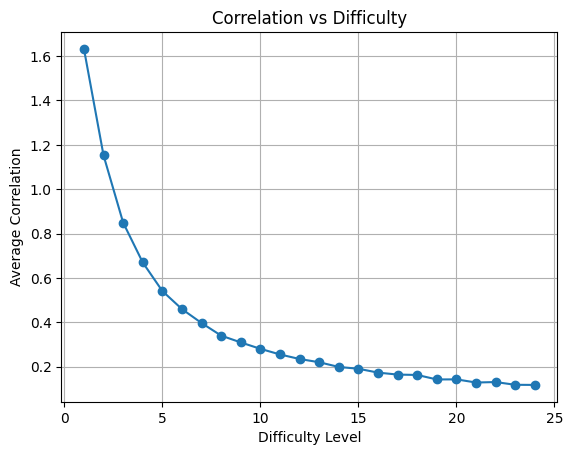

In [40]:
start_time = time.time()
difficulty = 1
correlation_values = []
difficulty_levels = []
while True:
    plaintext_filename = os.path.join("files", f"{PREFIX_PLAINTEXT_FILE_NAME}_{difficulty}_{AMOUNT_OF_TRACES}.txt")
    traces_filename = os.path.join("files", f"{PREFIX_TRACES_FILE_NAME}_{difficulty}_{AMOUNT_OF_TRACES}.txt")
    difficulty_levels.append(difficulty)
    traces = 10000
    key, corr = find_key(plaintext_filename, traces_filename, traces)
    print(key, corr)
    correlation_values.append(corr)
    if not check_if_correct_key(key, difficulty):
        elapsed_time = time.time() - start_time
        print(f"Total runtime: {elapsed_time:.2f} seconds")
        break
    print(f"{USER}, {key}, {difficulty}")
    difficulty += 1

  # Plotting the results
plt.plot(difficulty_levels, correlation_values, marker='o')
plt.xlabel('Difficulty Level')
plt.ylabel('Average Correlation')
plt.title('Correlation vs Difficulty')
plt.grid(True)
plt.show()
